In [1]:
import sys
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, random

from IPython.display import display

#from sklearn.decomposition import PCA
import sklearn.linear_model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.utils.vis_utils import plot_model

print(tf.version.VERSION)


2.9.2


In [2]:
%load_ext tensorboard

In [ ]:
#%tensorboard --logdir logs/fit

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper functions

In [6]:
def rebin(s, bins, wavelength_col = "w", value_col = "a", handle_nan = False):
    s['w_bins'] = pd.cut(s[wavelength_col], bins) # Cut the wavelength into bins
    s_bin = s.groupby(['w_bins'])[value_col].mean().reset_index() # Group by bin and average in the bin
    s = np.array(s_bin[value_col])
    if handle_nan:
        found = np.isnan(s)
        if found.any():
            s = [0 if found[i] else s[i] for i in range(len(s))]
        s = np.array(s)
    return s

def generate_bins(nr_bins):
    # Rebin the opacities
    bins = np.linspace(5.,35., num=nr_bins)#121)#[0, 5,10,15,20,25,30,35,40]
    new_wavelength = []
    for i in range(len(bins)):
        if i < len(bins)-1: 
            new_wavelength.append(bins[i]+(bins[i+1]-bins[i])/2)
    new_wavelength = np.array(new_wavelength)

    return bins, new_wavelength

def get_opacs(nr_bins=150):
    # Read in the opacities
    directory = "/content/drive/opacities"
    file_forsterite = 'Forsterite0.1.Kabs'
    opac_fo = np.loadtxt(os.path.join(directory, file_forsterite))
    file_amorphSilicate = 'AmorphousOlivineX0.5_0.1.Kabs'
    opac_am = np.loadtxt(os.path.join(directory, file_amorphSilicate))
    file_enstatite = 'Enstatite0.1.Kabs'
    opac_en = np.loadtxt(os.path.join(directory, file_enstatite))

    bins, new_wavelength = generate_bins(nr_bins)

    res = new_wavelength[1:-1] - new_wavelength[0:-2]
    opac_fo_df = pd.DataFrame(opac_fo, columns=['w', 'a'])
    opac_am_df = pd.DataFrame(opac_am, columns=['w', 'a'])
    opac_en_df = pd.DataFrame(opac_en, columns=['w', 'a'])

    opac_fo_bin = rebin(opac_fo_df, bins)
    opac_en_bin = rebin(opac_en_df, bins)
    opac_am_bin = rebin(opac_am_df, bins)

    return new_wavelength, [opac_fo_bin, opac_en_bin, opac_am_bin]

def calc_spectra(a_fo, a_en, a_am, T, nr_bins=150, opacs=[]):

    def B(lambd, T, micron=True):
        c = 299792458 # metres per second.
        h = 6.62607015e-34 # joule second
        k = 1.380649e-23 # joule per kelvin (K)

        if micron:
            lambd = lambd*1e-6
        return (2*h*c**2/lambd**5) * 1 / (np.exp(h*c/(k*T*lambd))-1)

    def syn_spec(w, a, opac, T):
        spec = np.zeros(opac[0].shape)
        for i in range(len(a)):
            spec = spec + a[i]*opac[i]
        f = B(w, T) * spec
        f = f/f.max()
        return f
    
    if len(opacs) == 0:
        w, opacs = get_opacs(nr_bins)
    else:
        w, opacs = opacs

    return w, syn_spec(w, (a_fo, a_en, a_am), opacs, T)

def generate_opticallythin_spectra(nr, nr_bins=150, \
        cr_a_min = 0, cr_a_max = 20,\
                                   #8, \
        T_min = 100, T_max = 500,\
                                   #300, \
        norm = True):

    # Generate parameters of the radiative model

    a_fo = np.array([random.uniform(cr_a_min,cr_a_max) for i in range(nr)])
    a_en = np.array([random.uniform(cr_a_min,cr_a_max) for i in range(nr)])
    a_am = [100-(a_fo[i]+a_en[i]) for i in range(nr)]
    Ts = np.array([random.uniform(T_min,T_max) for i in range(nr)])
    
    w, opacs = get_opacs(nr_bins=150)


    specs = np.array([calc_spectra(a_fo[i], a_en[i], a_am[i], Ts[i], nr_bins, [w,opacs])[1] for i in range(len(a_fo))])
    
    if norm:
        a_fo = a_fo/max(a_fo)#cr_a_max
        a_en = a_en/max(a_en)#cr_a_max
        Ts = Ts/max(Ts)#T_max

    grid = np.array([a_fo, a_en, Ts]).T
    
    return specs, grid

# From parameters to spectrum

In [7]:
def get_data(nr_train = 10000):
    nr_test = int(0.2* nr_train)
    a_fo_max, Ts_max = 8, 300
    
    # Now the spectra are the OUTPUT
    Y_train, train_grid = generate_opticallythin_spectra(\
        nr_train, \
        cr_a_min = 0, cr_a_max = a_fo_max, \
        T_min = 100, T_max = Ts_max, \
        norm = True)
    Y_test, test_grid = generate_opticallythin_spectra(\
        nr_test,\
        cr_a_min = 0, cr_a_max = a_fo_max, \
        T_min = 100, T_max = Ts_max, \
        norm = True)

    X_train = train_grid#.T
    X_test = test_grid#.T
    
    return X_train, Y_train, X_test, Y_test, a_fo_max, Ts_max

In [8]:
X_train, Y_train, X_test, Y_test, a_fo_max, Ts_max = get_data(100)
#Y_train[1]#.mean()

OSError: ignored

In [ ]:
def run_model(X_train, Y_train, X_test, Y_test, neurons = 128, learning_rate=0.005, epochs = 100, verbose=0, save_to=""):

    def make_model(input_shape, output_shape):
        input_data = tf.keras.Input(shape=input_shape)
        D = tf.keras.layers.Dense(units= neurons, activation='relu')(input_data)
#        D = tf.keras.layers.Dense(units= neurons, activation='relu')(D)
        output = tf.keras.layers.Dense(units= output_shape, name='output')(D)
        model = tf.keras.Model(inputs=input_data, outputs=output)
        return model

    model = make_model((X_train.shape[1],), (Y_train.shape[1]),)

    #display(plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #opt = tf.keras.optimizers.SGD(lr=learning_rate)
    metrics={'output': tf.keras.metrics.RootMeanSquaredError()}
    loss = {'output': tf.keras.losses.MeanSquaredError()}
    
    model.compile(optimizer=opt,
                     loss=loss,
                     metrics=metrics)

    history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test), verbose=verbose)
        
    if (save_to != ""):
        model.save(save_to)
    
    return history, model

In [ ]:
results, models = [], []
for p in [
          {'a': 0.01, 'n': 128, 'e':100, 'nr_train':100000},\
         ]:
    alpha = p['a']
    neurons = p['n']
    epochs = p['e']
    nr_train = p['nr_train']

    X_train, Y_train, X_test, Y_test, a_fo_max_train, Ts_max_train  = get_data(nr_train)
    a_en_max_train = a_fo_max_train
    
    checkpoint_path = "NN_synthspectra_simple_final_models/param-to-spec/model_"+str(epochs)
    checkpoint_dir = os.path.dirname(checkpoint_path)
    try:
        model = tf.keras.models.load_model(checkpoint_path)
        print("Model read from disk")
        model.summary()
        loss, acc = model.evaluate(X_train, Y_train, verbose=2)
    except:
        print("No model found")

        history, model = run_model(
            X_train, Y_train, X_test, Y_test,
            neurons = neurons, learning_rate=alpha, 
            epochs = epochs, verbose=1, save_to=checkpoint_path)

        results.append([alpha, neurons, epochs,nr_train,
                        history.history['loss'][-1], 
                        history, model.predict(X_test),
                        model, Y_test])
        plt.plot(history.history['loss'], \
             label="loss"+\
             ", a: "+str(alpha)+\
             ", n: "+str(neurons)+\
             ", e: "+str(epochs)+\
             ", nr: "+str(nr_train))
        plt.show()
        
    models.append(model)    
        
    #print('nr_train: ', nr_train, 'neurons: ', neurons, 'alpha: ', alpha, 'epochs: ', epochs, 'loss: ', history.history['loss'][-1])

No model found
Epoch 1/100
3125/3125 [==============================] - 6s 2ms/step - loss: 9.7339e-04 - root_mean_squared_error: 0.0312 - val_loss: 2.1173e-04 - val_root_mean_squared_error: 0.0146
Epoch 2/100
3125/3125 [==============================] - 5s 2ms/step - loss: 7.8256e-05 - root_mean_squared_error: 0.0088 - val_loss: 4.2899e-05 - val_root_mean_squared_error: 0.0065
Epoch 3/100
3125/3125 [==============================] - 5s 2ms/step - loss: 5.9691e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.3350e-05 - val_root_mean_squared_error: 0.0058
Epoch 4/100
3125/3125 [==============================] - 5s 2ms/step - loss: 5.5494e-05 - root_mean_squared_error: 0.0074 - val_loss: 4.3730e-05 - val_root_mean_squared_error: 0.0066
Epoch 5/100
3125/3125 [==============================] - 5s 2ms/step - loss: 4.9180e-05 - root_mean_squared_error: 0.0070 - val_loss: 3.1588e-05 - val_root_mean_squared_error: 0.0056
Epoch 6/100
3125/3125 [==============================] - 5s 2ms/step -

3125/3125 [==============================] - 5s 2ms/step - loss: 3.4440e-05 - root_mean_squared_error: 0.0059 - val_loss: 2.4396e-05 - val_root_mean_squared_error: 0.0049
Epoch 90/100
3125/3125 [==============================] - 6s 2ms/step - loss: 3.5197e-05 - root_mean_squared_error: 0.0059 - val_loss: 3.1279e-05 - val_root_mean_squared_error: 0.0056
Epoch 91/100
3125/3125 [==============================] - 6s 2ms/step - loss: 3.5452e-05 - root_mean_squared_error: 0.0060 - val_loss: 2.3687e-05 - val_root_mean_squared_error: 0.0049
Epoch 92/100
3125/3125 [==============================] - 5s 2ms/step - loss: 3.5093e-05 - root_mean_squared_error: 0.0059 - val_loss: 3.6038e-05 - val_root_mean_squared_error: 0.0060
Epoch 93/100
3125/3125 [==============================] - 5s 2ms/step - loss: 3.5188e-05 - root_mean_squared_error: 0.0059 - val_loss: 2.2164e-05 - val_root_mean_squared_error: 0.0047
Epoch 94/100
3125/3125 [==============================] - 5s 1ms/step - loss: 3.5234e-05 - ro

In [ ]:
#display(plot_model(models[0], show_shapes=True, show_layer_names=True, to_file='outer-model.png'))

Using matplotlib backend: nbAgg
3125/3125 [==============================] - 3s 990us/step


<IPython.core.display.Javascript object>


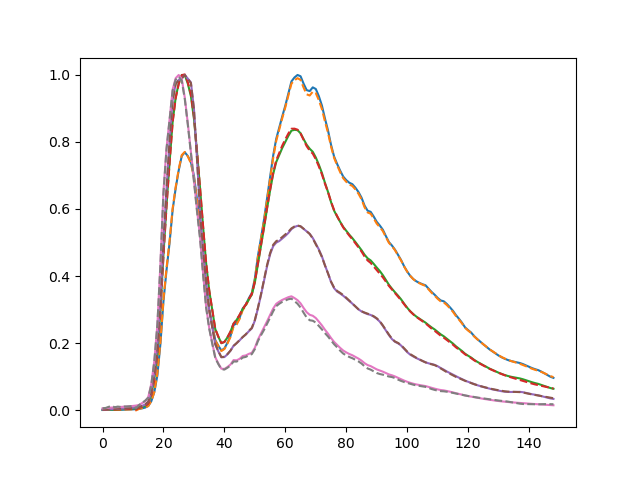

In [ ]:
%matplotlib auto 
X_train, Y_train, X_test, Y_test, a_fo_max_train, Ts_max_train  = get_data(nr_train)
Y_pred = models[0].predict(X_train)
for i in [random.randint(0,len(Y_train)) for j in range(4)]:
    plt.plot(Y_train[i])
    plt.plot(Y_pred[i], "--")
plt.show()

<IPython.core.display.Javascript object>


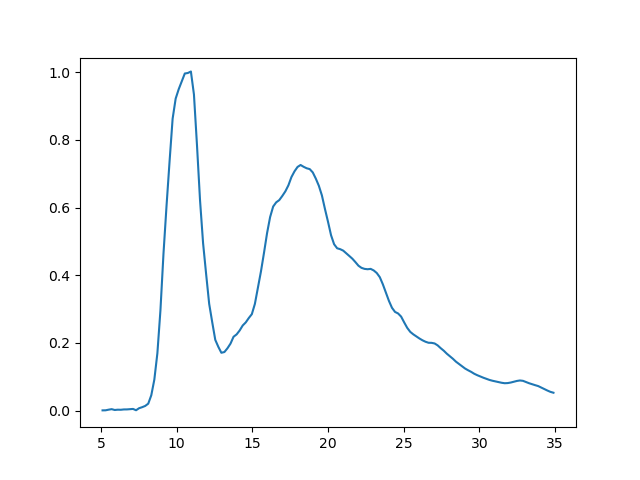

interactive(children=(FloatSlider(value=4.0, description='a_fo', max=20.0), FloatSlider(value=4.0, description…

In [ ]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

X_train, Y_train, X_test, Y_test, a_fo_max_train,  Ts_max_train = get_data(10)

bins, w = generate_bins(nr_bins=150)
#x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(w, models[0].predict([[1/a_fo_max_train, 1/a_fo_max_train, 200/Ts_max_train]], verbose=0)[0] )

def update(a_fo = 4, a_en = 4, T = 200):
   
    Y_pred = models[0].predict([[a_fo/a_fo_max_train, a_en/a_fo_max_train, T/Ts_max_train]], verbose=0)[0]
    line.set_ydata(Y_pred)
    fig.canvas.draw_idle()

    
#controls = iplt.plot(x, f, w=(1, 10))    
    
#    , freq=(0.0,100.0)
interact(update, a_fo=(0.0, 20.0), a_en=(0.0, 20.0), T=(100, 500) );